In [1]:
# !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
# !bash install_colab.sh

In [1]:
from icevision.all import *

# Loading dataset

In [2]:
# Location of the image root
# Update the path of the nikelogs
data_dir = Path('./nikelogos')

# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "annotations", images_dir=data_dir / "images")
parser.class_map


# Parse annotations to create records
train_records, valid_records = parser.parse()

# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize(), tfms.A.Rotate()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

len(train_ds), len(valid_ds)

INFO     - Autofixing records | icevision.parsers.parser:parse:136


WARNING  - (record_id: 340) - 🚫 Record could not be autofixed and will be removed because: File 'nikelogos/images/nike_logo_tshirt_362.jpg' does not exist | icevision.core.record:autofix_records:100
WARNING  - (record_id: 250) - 🚫 Record could not be autofixed and will be removed because: File 'nikelogos/images/nike_logo_shoes_528.jpg' does not exist | icevision.core.record:autofix_records:100


(404, 102)

# Making model

In [3]:
# Just change the value of selection to try another model

selection = 3 # !!! Zero will lead to error in signle image inference  


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model = model_type.model(backbone=backbone(pretrained=True),num_classes=len(parser.class_map), **extra_args)


# Making dataloader

In [4]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

# Training the model

In [7]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learner1 = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)


## Freeze

0 :  lr_min,lr_steep:  0.0025118865072727204 0.002511886414140463


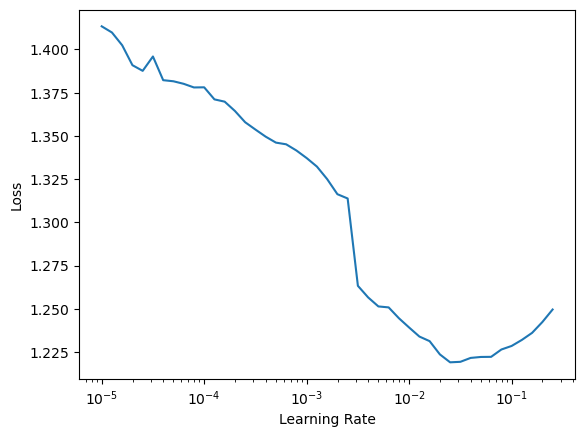

In [13]:
learner1.freeze()
lr_min0,lr_steep0 = learner1.lr_find(start_lr=1e-5, end_lr=1, num_it=50, stop_div=True, show_plot=True, suggestions=True)
print("0 :", " lr_min,lr_steep: ",lr_min0,lr_steep0)
# lr = lr_min0/10
lr = 0.002

epoch,train_loss,valid_loss,COCOMetric,time
0,1.216023,1.081538,0.091405,00:05
1,1.078559,0.943926,0.099400,00:05
2,0.975704,0.866029,0.115360,00:05
3,0.923338,0.833852,0.141488,00:05
4,0.880344,0.823207,0.133195,00:05


1  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.804240,0.788889,0.159707,00:05
1,0.801668,0.774385,0.233585,00:05
2,0.787500,0.744790,0.223724,00:05
3,0.765959,0.716032,0.237365,00:05
4,0.746322,0.703118,0.253091,00:05


2  lr_min,lr_steep:  0.0003981071524322033 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.720594,0.709465,0.258223,00:05
1,0.723531,0.691443,0.283771,00:05
2,0.718162,0.651964,0.258915,00:05
3,0.705169,0.634506,0.315355,00:05
4,0.694000,0.624409,0.315537,00:05


3  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.661704,0.624270,0.259776,00:05
1,0.677129,0.684228,0.176749,00:05
2,0.663442,0.630535,0.247074,00:05
3,0.653926,0.620514,0.315508,00:05
4,0.641660,0.597858,0.329435,00:05


4  lr_min,lr_steep:  0.0005011872388422489 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.627394,0.608281,0.269323,00:05
1,0.636531,0.645965,0.187276,00:05
2,0.640552,0.617882,0.230648,00:05
3,0.641389,0.597665,0.261117,00:05
4,0.630508,0.585070,0.297730,00:05


5  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.611626,0.583739,0.306824,00:05
1,0.617640,0.626145,0.268043,00:05
2,0.615389,0.593663,0.221197,00:05
3,0.604499,0.558201,0.311737,00:05
4,0.602740,0.543470,0.335024,00:05


6  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.578220,0.556933,0.246533,00:05
1,0.602004,0.573522,0.250737,00:05
2,0.602587,0.546765,0.366188,00:05
3,0.600534,0.520598,0.349693,00:05
4,0.591264,0.529505,0.341993,00:05


7  lr_min,lr_steep:  6.30957365501672e-06 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.570286,0.548721,0.310403,00:05
1,0.596853,0.550160,0.284774,00:05
2,0.589426,0.521509,0.350776,00:05
3,0.595384,0.534922,0.350264,00:05
4,0.581796,0.514801,0.365964,00:05


8  lr_min,lr_steep:  0.0003981071524322033 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.551775,0.538505,0.333615,00:05
1,0.566240,0.536145,0.290349,00:05
2,0.571676,0.534161,0.323219,00:05
3,0.566991,0.515386,0.383060,00:05
4,0.557073,0.518576,0.407978,00:05


9  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.541623,0.504732,0.356405,00:05
1,0.563006,0.539350,0.404522,00:05
2,0.562321,0.520185,0.429006,00:05
3,0.563721,0.499127,0.437376,00:05
4,0.554637,0.490985,0.446555,00:05


10  lr_min,lr_steep:  0.0003162277629598975 3.162277789670043e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.526635,0.495681,0.400762,00:05
1,0.543854,0.518444,0.408138,00:06
2,0.551648,0.515026,0.398001,00:05
3,0.544125,0.491143,0.400748,00:05
4,0.538165,0.477143,0.447046,00:05


11  lr_min,lr_steep:  3.162277789670043e-06 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.531986,0.510440,0.434398,00:05
1,0.541611,0.527645,0.314466,00:05
2,0.543500,0.502901,0.368497,00:05
3,0.542169,0.499036,0.399997,00:05
4,0.539940,0.486701,0.430690,00:05


12  lr_min,lr_steep:  0.0003981071524322033 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.524193,0.484652,0.401676,00:06
1,0.545100,0.507931,0.414757,00:05
2,0.549131,0.516756,0.350069,00:05
3,0.541255,0.498346,0.415215,00:05
4,0.536058,0.487669,0.421266,00:05


13  lr_min,lr_steep:  0.0006309573538601399 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.523232,0.479998,0.452379,00:05
1,0.528795,0.495176,0.430354,00:05
2,0.534986,0.506365,0.451261,00:05
3,0.533525,0.480579,0.432874,00:05
4,0.525726,0.474679,0.444761,00:05


14  lr_min,lr_steep:  5.01187241752632e-06 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.506014,0.488081,0.442267,00:05
1,0.522065,0.491183,0.406748,00:05
2,0.524358,0.475770,0.470321,00:05
3,0.521959,0.479963,0.434492,00:05
4,0.523065,0.461218,0.476248,00:05


15  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.507470,0.468287,0.471438,00:05
1,0.527829,0.504678,0.389339,00:05
2,0.528818,0.487555,0.453601,00:05
3,0.524824,0.462768,0.450799,00:05
4,0.519796,0.464851,0.466509,00:05


16  lr_min,lr_steep:  3.162277789670043e-06 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.531727,0.492938,0.386621,00:05
1,0.535416,0.488229,0.545030,00:05
2,0.529882,0.469979,0.479470,00:05
3,0.524218,0.472578,0.480085,00:05
4,0.518280,0.460099,0.504912,00:05


17  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.509568,0.470748,0.519201,00:05
1,0.515499,0.482646,0.472845,00:05
2,0.521219,0.487953,0.485871,00:05
3,0.518111,0.460096,0.501172,00:05
4,0.514617,0.457920,0.507536,00:05


18  lr_min,lr_steep:  3.162277789670043e-06 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.490354,0.476481,0.469441,00:05
1,0.508079,0.489755,0.478583,00:05
2,0.514747,0.487418,0.404511,00:05
3,0.506802,0.463827,0.477823,00:05
4,0.511509,0.450625,0.491358,00:05


19  lr_min,lr_steep:  0.0006309573538601399 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.488680,0.464832,0.514572,00:05
1,0.498962,0.475829,0.449776,00:05
2,0.501294,0.467149,0.501230,00:05
3,0.505342,0.473889,0.483788,00:05
4,0.501191,0.464830,0.491417,00:05


20  lr_min,lr_steep:  0.0003981071524322033 0.002511886414140463


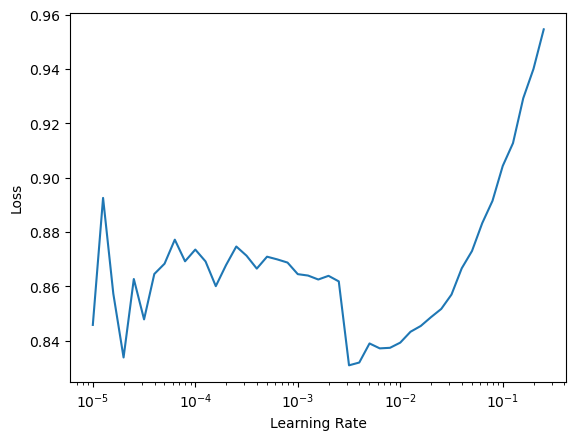

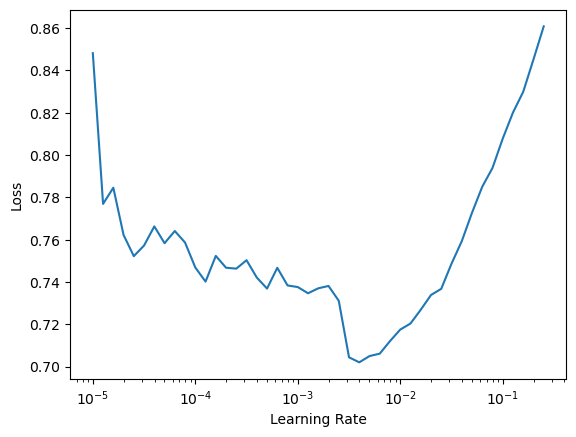

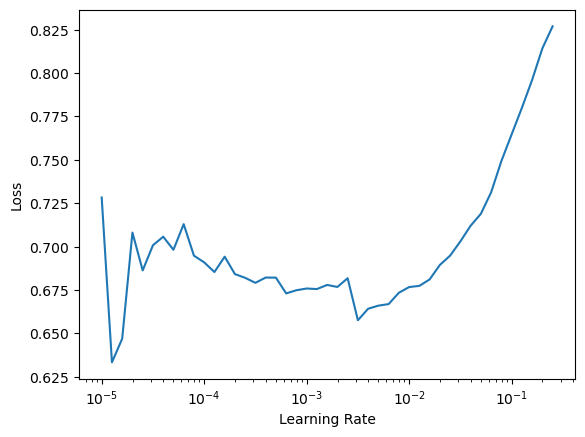

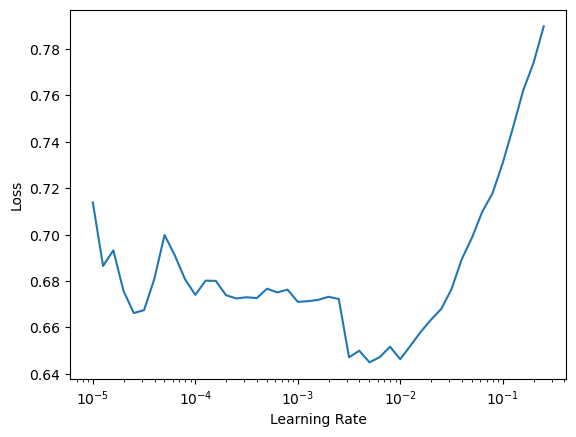

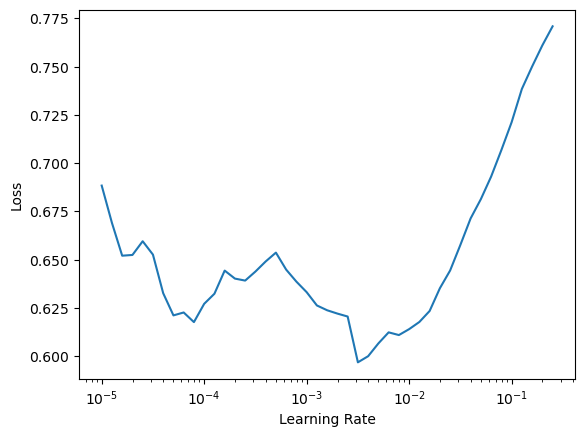

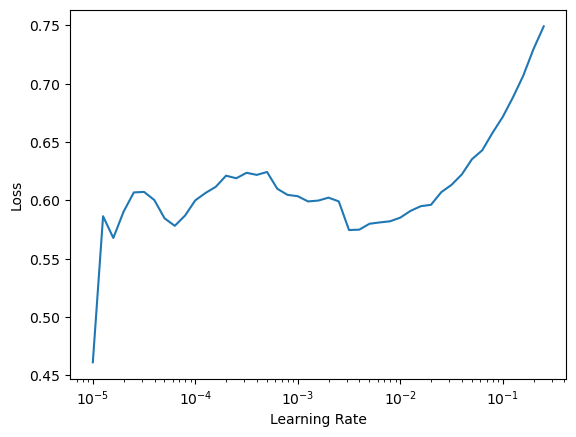

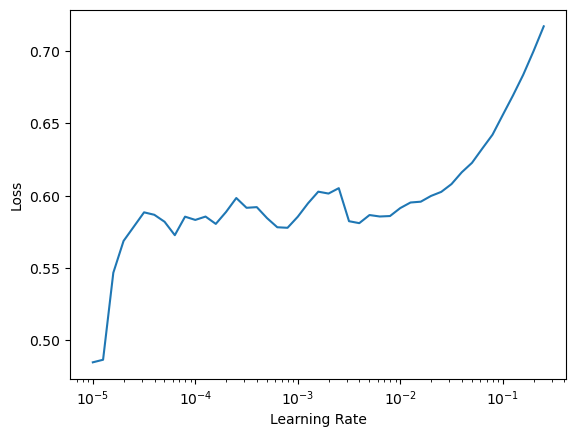

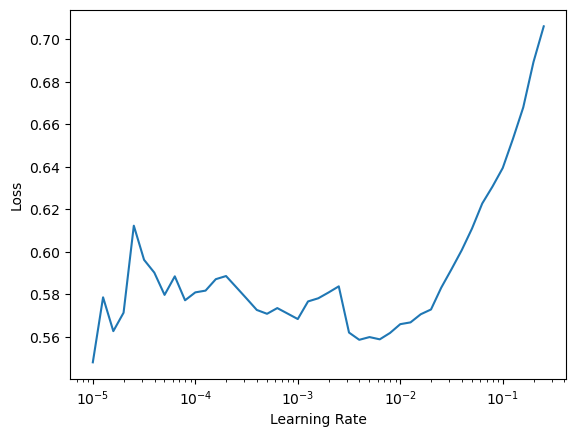

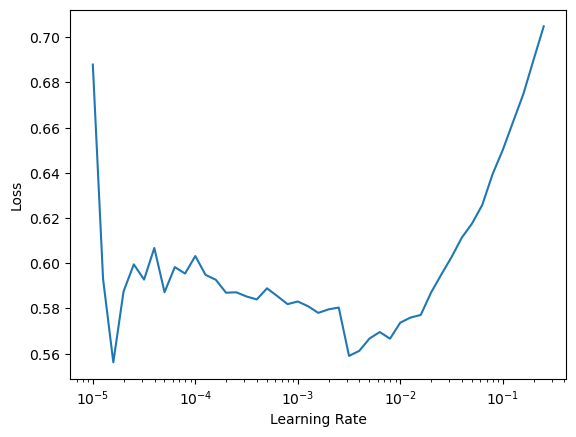

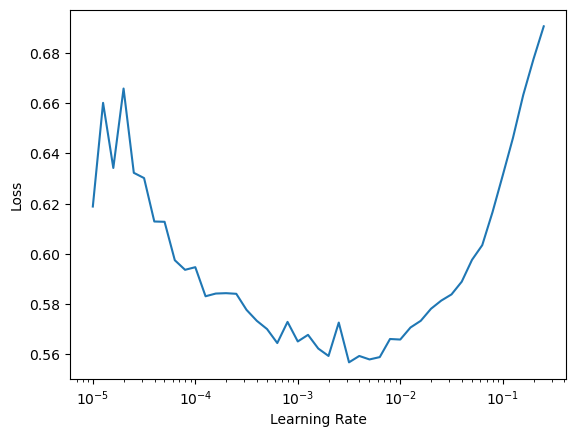

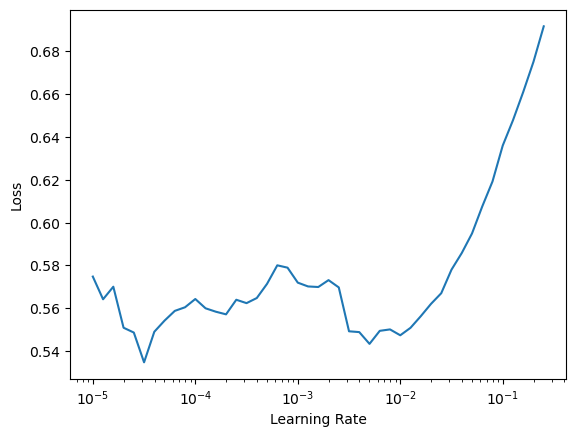

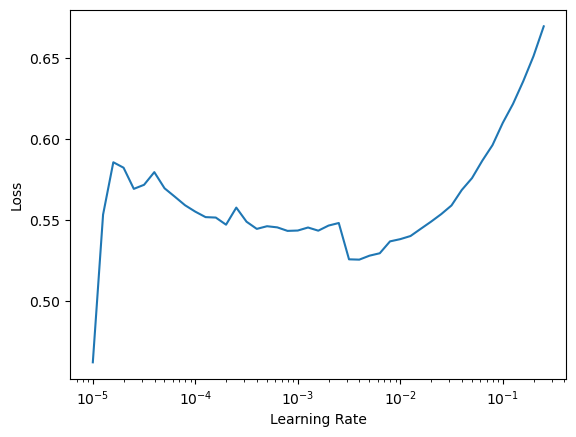

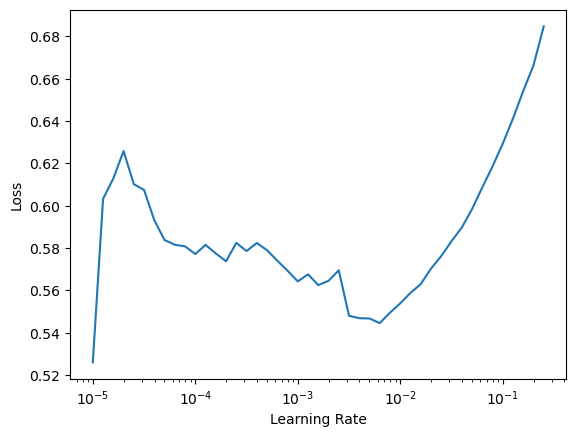

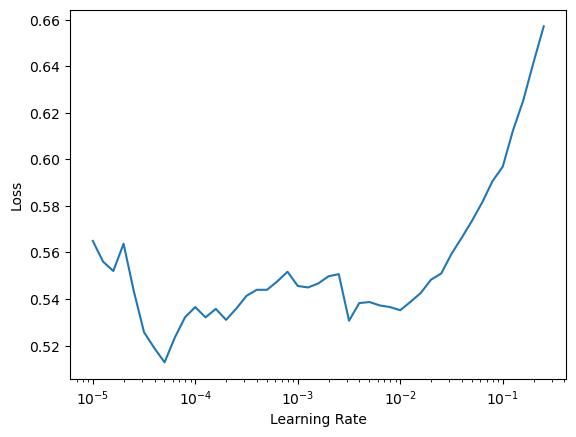

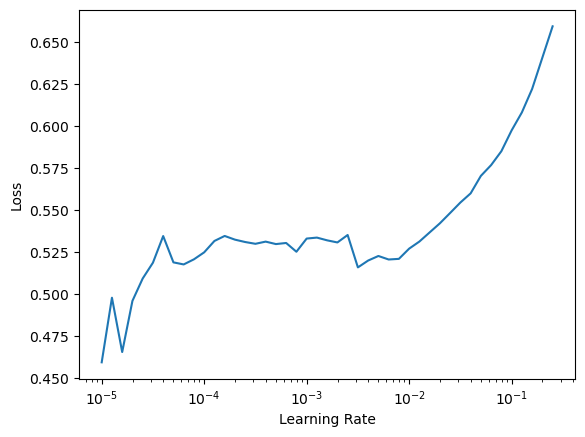

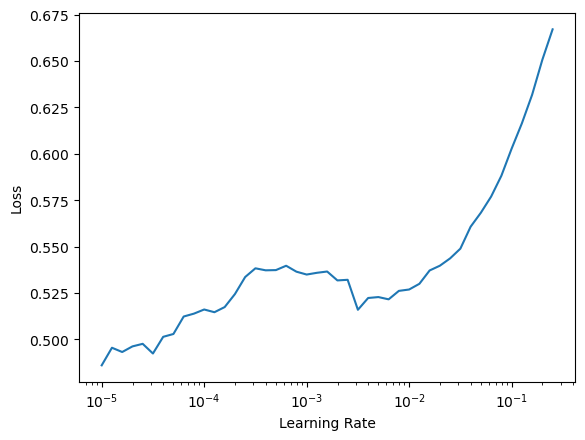

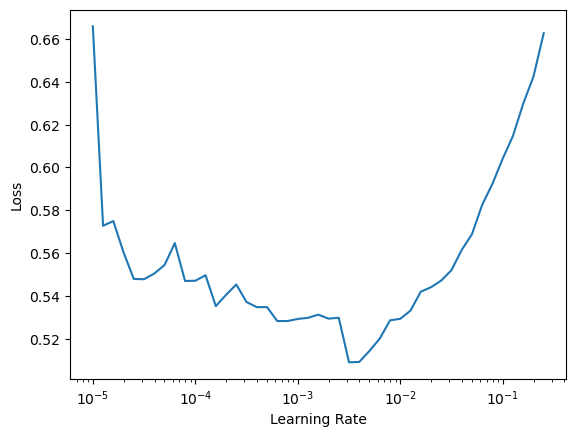

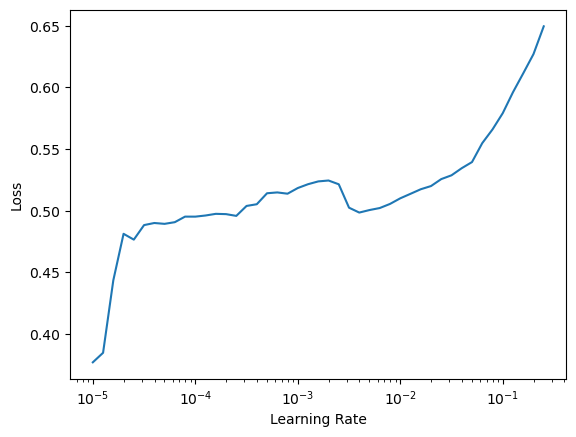

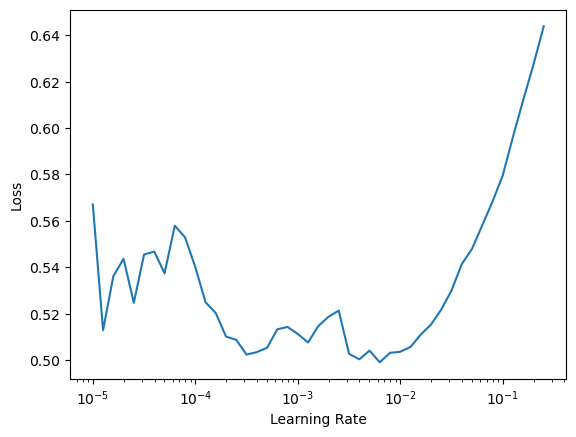

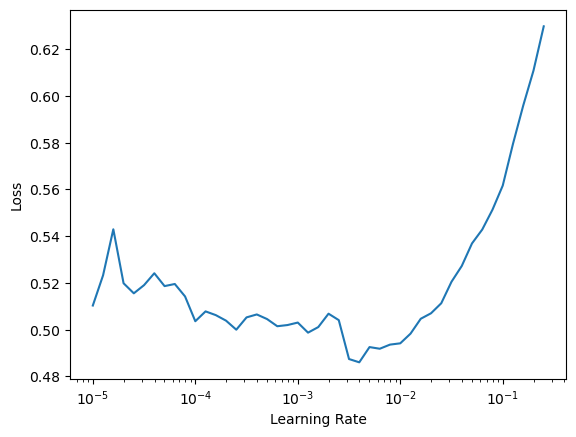

In [14]:

for i in range(20):


    n_epochs = 5
    learner1.fit_one_cycle(n_epochs,lr)
    
    PATH = f"model_3_freeze_{(i+1)*n_epochs}.mm"
    print("file:", PATH)
    torch.save(model.state_dict(), PATH)
    
    lr_min0,lr_steep0 = learner1.lr_find(start_lr=1e-5, end_lr=1, num_it=50, stop_div=True, show_plot=True, suggestions=True)
    print((i+1), " lr_min,lr_steep: ",lr_min0,lr_steep0)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.501997,0.472531,0.459495,00:05
1,0.507324,0.483490,0.476597,00:05
2,0.518720,0.469489,0.509494,00:05
3,0.512956,0.467450,0.503075,00:05
4,0.505529,0.458843,0.524816,00:05


path model_3_freeze_100.mm


20  lr_min,lr_steep:  3.162277789670043e-06 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.486145,0.463742,0.514134,00:05
1,0.510001,0.511823,0.467731,00:05
2,0.511998,0.484229,0.454247,00:05
3,0.512036,0.459905,0.498965,00:05
4,0.507736,0.451145,0.514485,00:05


path model_3_freeze_105.mm


21  lr_min,lr_steep:  0.0003981071524322033 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.509104,0.466477,0.427841,00:05
1,0.508632,0.473808,0.471104,00:05
2,0.509686,0.478254,0.486838,00:05
3,0.501388,0.469514,0.523555,00:05
4,0.500831,0.461039,0.531713,00:05


path model_3_freeze_110.mm


22  lr_min,lr_steep:  0.0005011872388422489 6.30957365501672e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.498012,0.468681,0.487757,00:05
1,0.507586,0.476618,0.457186,00:05
2,0.501520,0.472309,0.458277,00:05
3,0.490953,0.457787,0.461717,00:05
4,0.489926,0.454027,0.463074,00:05


path model_3_freeze_115.mm


23  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.500926,0.448770,0.499177,00:05
1,0.507948,0.485043,0.403226,00:05
2,0.513372,0.468890,0.491432,00:05
3,0.505898,0.451137,0.485578,00:05
4,0.500901,0.444432,0.526299,00:05


path model_3_freeze_120.mm


24  lr_min,lr_steep:  0.0003162277629598975 5.0118724175263196e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.477596,0.457451,0.443454,00:05
1,0.494081,0.484395,0.508195,00:05
2,0.491523,0.473429,0.469065,00:05
3,0.490124,0.450435,0.531340,00:05
4,0.489169,0.440626,0.554223,00:05


path model_3_freeze_125.mm


25  lr_min,lr_steep:  0.0003162277629598975 3.162277789670043e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.481469,0.452958,0.532660,00:05
1,0.494416,0.472227,0.496988,00:05
2,0.506939,0.459598,0.490380,00:05
3,0.498362,0.461290,0.514156,00:05
4,0.495532,0.450151,0.523723,00:05


path model_3_freeze_130.mm


26  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.506411,0.449775,0.473995,00:05
1,0.505065,0.504726,0.378077,00:05
2,0.505549,0.443086,0.512892,00:05
3,0.492683,0.449782,0.484169,00:05
4,0.494760,0.440923,0.504380,00:05


path model_3_freeze_135.mm


27  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.486184,0.503065,0.422644,00:05
1,0.503301,0.460726,0.487729,00:05
2,0.498485,0.454542,0.485190,00:05
3,0.496024,0.437201,0.502504,00:05
4,0.492342,0.433824,0.506114,00:05


path model_3_freeze_140.mm


28  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.488550,0.445596,0.492416,00:05
1,0.499211,0.466228,0.465990,00:05
2,0.503650,0.456748,0.455952,00:05
3,0.489411,0.447422,0.443873,00:05
4,0.480542,0.446995,0.455255,00:05


path model_3_freeze_145.mm


29  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.481310,0.447779,0.483748,00:05
1,0.486475,0.471171,0.471896,00:05
2,0.489632,0.470318,0.429568,00:05
3,0.492597,0.436796,0.483306,00:05
4,0.486256,0.433902,0.504029,00:05


path model_3_freeze_150.mm


30  lr_min,lr_steep:  1.584893179824576e-05 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.470188,0.457954,0.522709,00:05
1,0.474720,0.469467,0.507702,00:05
2,0.491367,0.453556,0.495829,00:05
3,0.484185,0.453073,0.524008,00:05
4,0.477840,0.445711,0.512551,00:05


path model_3_freeze_155.mm


31  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.469833,0.429985,0.489145,00:05
1,0.473820,0.465182,0.464879,00:05
2,0.486137,0.433897,0.537690,00:05
3,0.487104,0.450561,0.532507,00:05
4,0.478606,0.446616,0.531079,00:05


path model_3_freeze_160.mm


32  lr_min,lr_steep:  3.981071859016083e-06 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.480100,0.436920,0.514249,00:05
1,0.479284,0.466827,0.411217,00:05
2,0.484838,0.468633,0.448454,00:05
3,0.482425,0.434222,0.528363,00:05
4,0.479151,0.433628,0.527462,00:05


path model_3_freeze_165.mm


33  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.456510,0.441058,0.541294,00:05
1,0.477686,0.479258,0.481790,00:05
2,0.479318,0.455362,0.474593,00:05
3,0.483553,0.445627,0.569535,00:05
4,0.475973,0.436733,0.599142,00:05


path model_3_freeze_170.mm


34  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.482912,0.446844,0.541354,00:05
1,0.482133,0.475427,0.424021,00:05
2,0.481603,0.456887,0.530793,00:05
3,0.482834,0.441132,0.528729,00:05
4,0.477932,0.441840,0.544821,00:05


path model_3_freeze_175.mm


35  lr_min,lr_steep:  0.0003162277629598975 3.981071859016083e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.462704,0.452288,0.500573,00:05
1,0.476286,0.466327,0.537392,00:05
2,0.477817,0.451602,0.552263,00:05
3,0.479876,0.444340,0.533341,00:05
4,0.473719,0.443112,0.523589,00:05


path model_3_freeze_180.mm


36  lr_min,lr_steep:  0.0003162277629598975 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.464093,0.453848,0.462550,00:05
1,0.477973,0.453525,0.502844,00:05
2,0.486182,0.451099,0.544667,00:05
3,0.476241,0.435360,0.516752,00:05
4,0.470618,0.432022,0.519901,00:05


path model_3_freeze_185.mm


37  lr_min,lr_steep:  3.162277789670043e-06 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.453688,0.457944,0.494008,00:05
1,0.471240,0.468120,0.441844,00:05
2,0.477985,0.450107,0.529676,00:05
3,0.477620,0.433360,0.506125,00:05
4,0.468015,0.428702,0.544875,00:05


path model_3_freeze_190.mm


38  lr_min,lr_steep:  0.0003981071524322033 0.002511886414140463


epoch,train_loss,valid_loss,COCOMetric,time
0,0.454486,0.472805,0.460738,00:05
1,0.482569,0.462007,0.464699,00:05
2,0.478833,0.440819,0.540832,00:05
3,0.474333,0.460693,0.452865,00:05
4,0.472472,0.455545,0.458389,00:05


path model_3_freeze_195.mm


39  lr_min,lr_steep:  0.0005011872388422489 0.002511886414140463


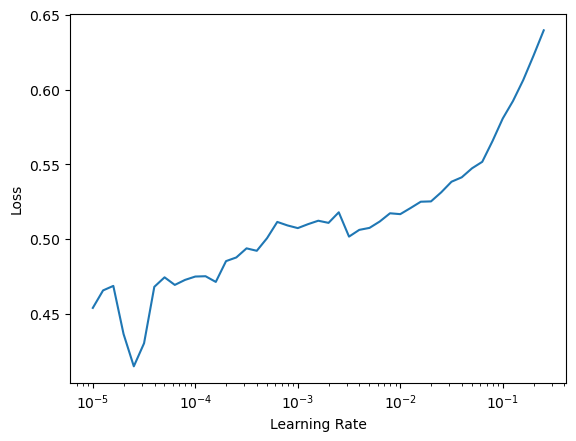

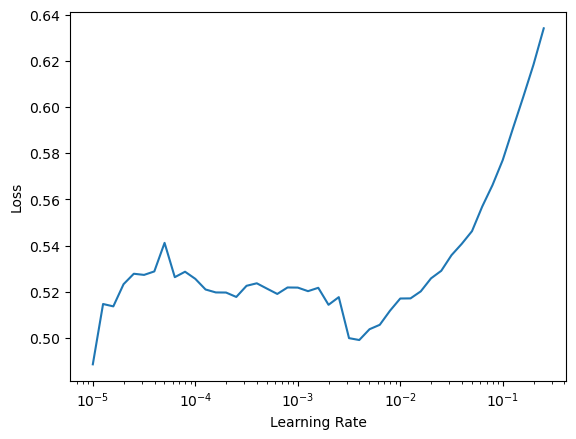

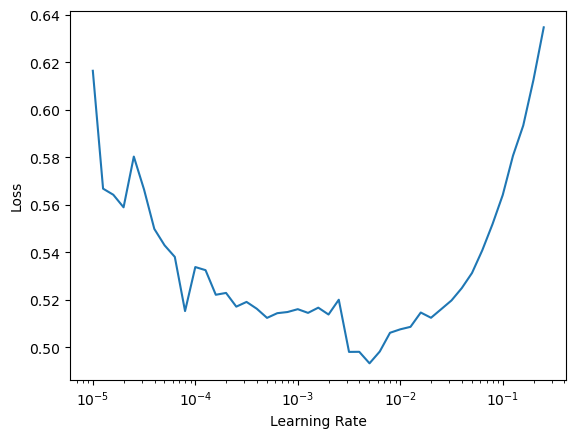

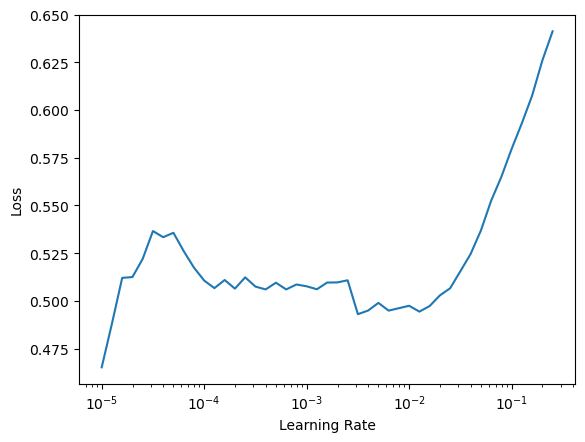

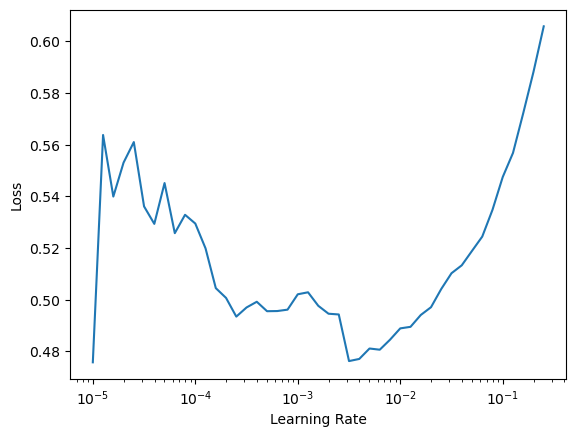

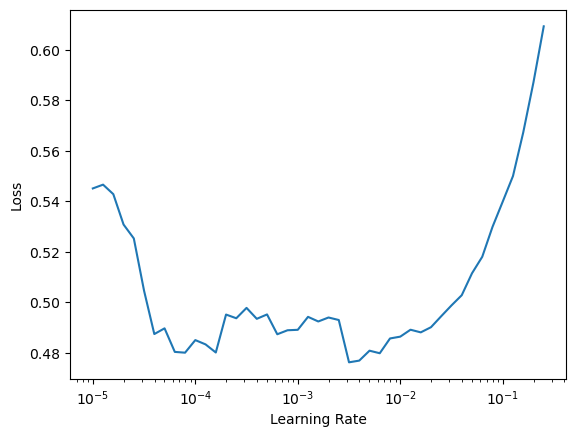

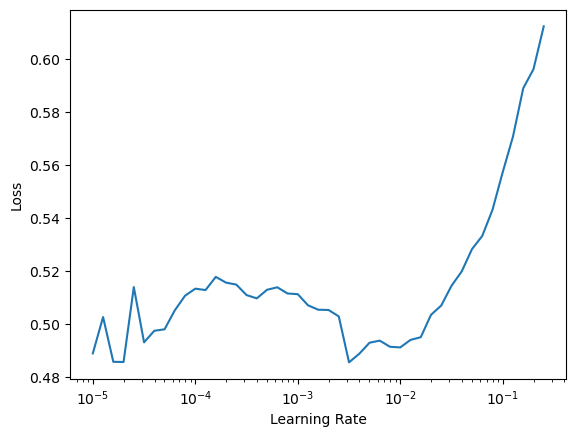

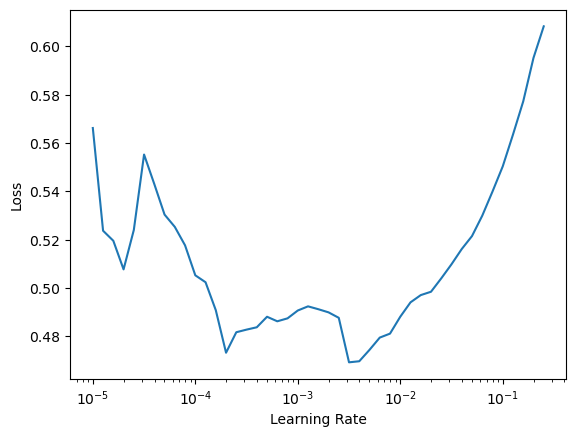

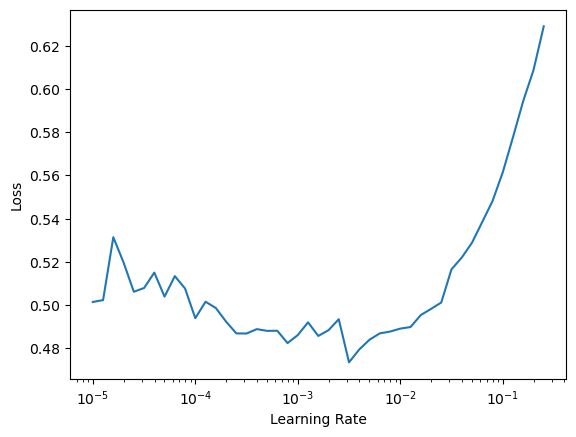

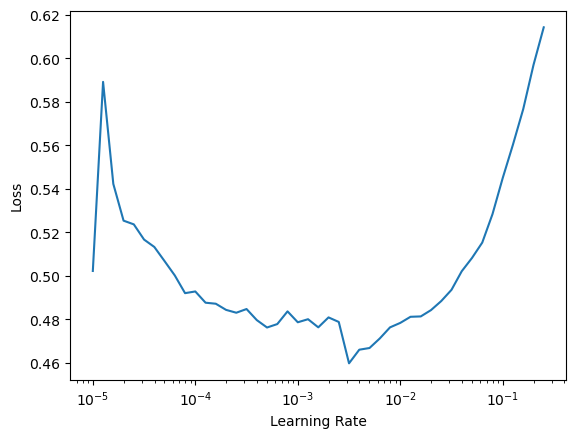

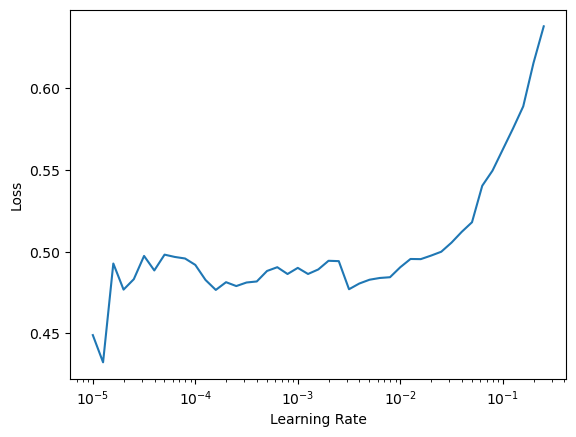

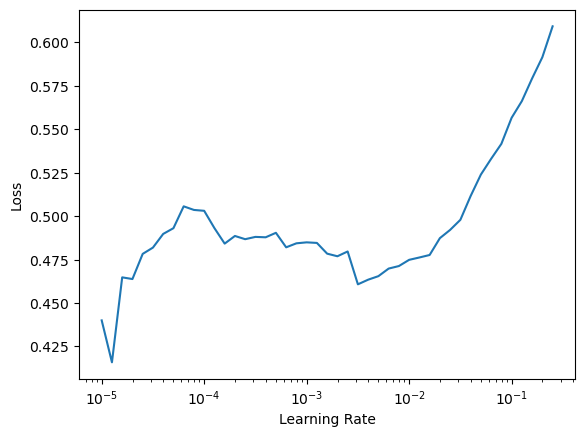

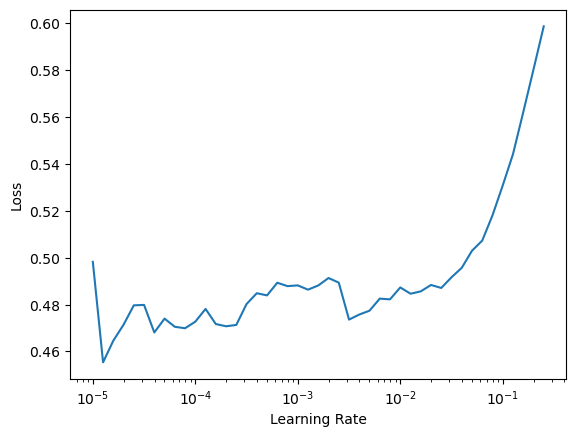

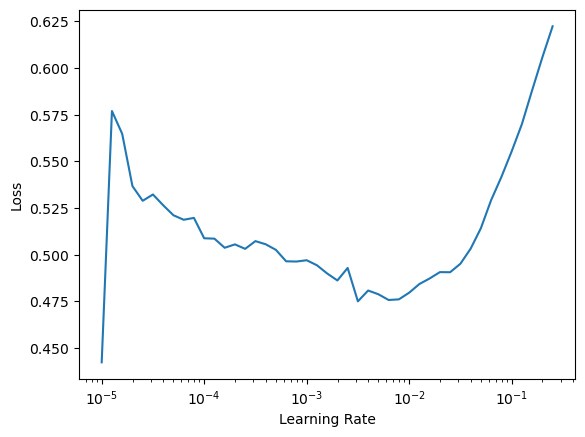

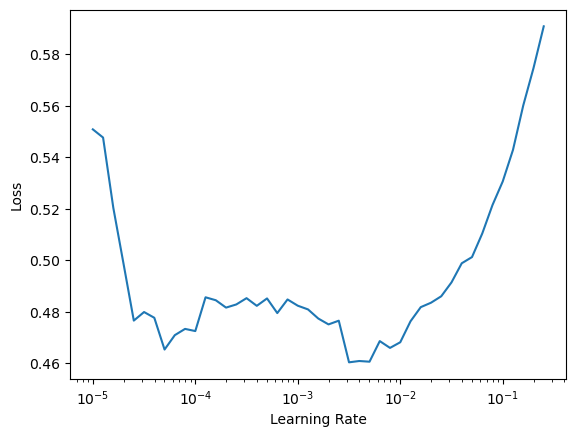

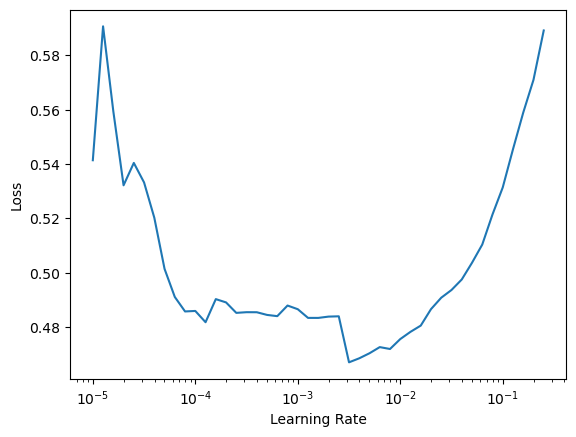

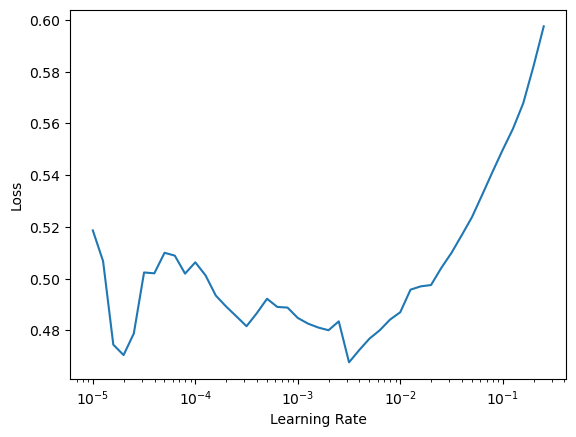

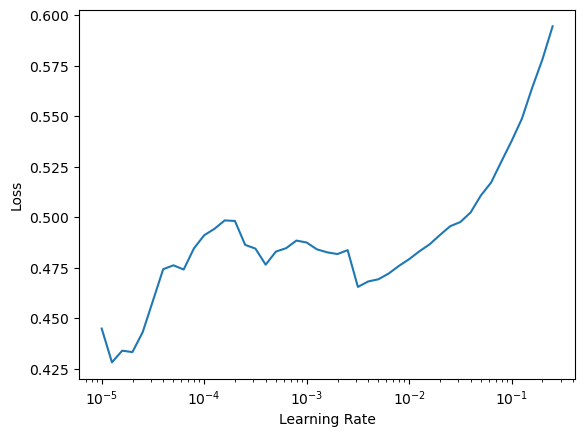

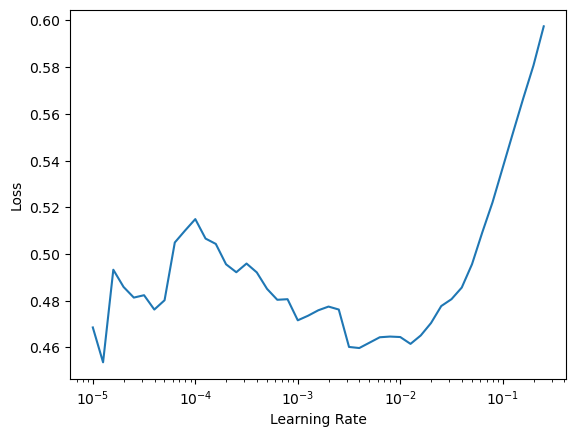

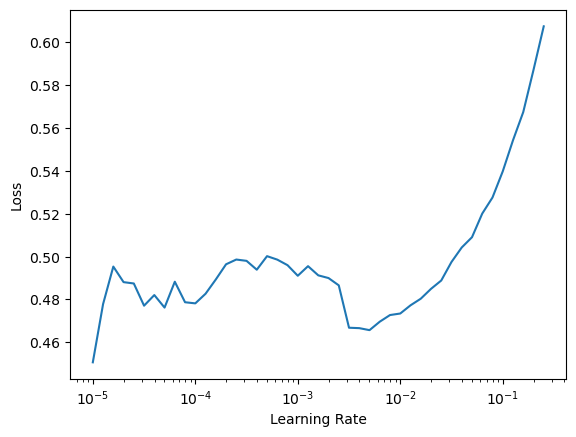

In [21]:
epoch_start = 95
 
model_path = f"model_3_freeze_{epoch_start}.mm"
device = torch.device('cuda')
model.load_state_dict(torch.load(model_path, map_location=device))

i_start = int(epoch_start/5)
for i in range(i_start, i_start+20):


    n_epochs = 5
    learner1.fit_one_cycle(n_epochs,lr)
    
    PATH = f"model_3_freeze_{(i+1)*n_epochs}.mm"
    print("file:", PATH)
    torch.save(model.state_dict(), PATH)
    
    lr_min0,lr_steep0 = learner1.lr_find(start_lr=1e-5, end_lr=1, num_it=50, stop_div=True, show_plot=True, suggestions=True)
    print((i+1), " lr_min,lr_steep: ",lr_min0,lr_steep0)

## unfreeze

In [8]:
# load freeze results
model_path = "model_3_freeze_170.mm"
device = torch.device('cuda')
model.load_state_dict(torch.load(model_path, map_location=device))



<All keys matched successfully>

In [9]:
learner1.unfreeze()
# lr_min0,lr_steep0 = learner1.lr_find(start_lr=1e-7, end_lr=1e-1, num_it=50, stop_div=True, show_plot=True, suggestions=True)
# print("0 :", " lr_min,lr_steep: ",lr_min0,lr_steep0)
# lr = lr_min0/10
# lr = 2e-5 # not too bad
# lr = slice(2e-5/10,2e-5) # better than above
# lr = slice(2e-5/100,2e-5) # started very well then dropped
# lr = slice(2e-6/10,2e-6) # meh
# lr = 2e-6 # good
lr = 2e-7 # very good
# lr = slice(8e-5/1000,8e-5) # started very well then dropped


epoch,train_loss,valid_loss,COCOMetric,time
0,0.486114,0.377729,0.669426,00:07
1,0.490616,0.376721,0.678520,00:05
2,0.485948,0.378452,0.668462,00:05
3,0.488000,0.380274,0.665598,00:06
4,0.491688,0.380885,0.665593,00:05


file: model_3_unfreeze_5.mm


1  lr_min,lr_steep:  1.3182566908653825e-05 7.585775892948732e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.490225,0.377721,0.658625,00:05
1,0.486767,0.378257,0.662236,00:06
2,0.492930,0.377289,0.657486,00:06
3,0.496130,0.378025,0.658597,00:05
4,0.487535,0.381000,0.650084,00:06


file: model_3_unfreeze_10.mm


2  lr_min,lr_steep:  3.0199516913853586e-05 7.585775892948732e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.476618,0.380187,0.647463,00:05
1,0.477949,0.381127,0.651760,00:05
2,0.486055,0.379318,0.651332,00:05
3,0.484854,0.380051,0.659748,00:05
4,0.480571,0.378869,0.652105,00:05


file: model_3_unfreeze_15.mm


3  lr_min,lr_steep:  9.12010818865383e-08 7.585775892948732e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.494191,0.379483,0.658371,00:05
1,0.478852,0.381284,0.658466,00:05
2,0.484678,0.382145,0.664424,00:05
3,0.494387,0.380345,0.661134,00:05
4,0.496847,0.378591,0.683222,00:06


file: model_3_unfreeze_20.mm


4  lr_min,lr_steep:  9.999999747378752e-06 3.981071756697929e-07


epoch,train_loss,valid_loss,COCOMetric,time
0,0.480535,0.378934,0.673602,00:05
1,0.482539,0.379922,0.670429,00:05
2,0.479379,0.379311,0.665453,00:06
3,0.478975,0.379862,0.667625,00:05
4,0.483587,0.382475,0.659491,00:06


file: model_3_unfreeze_25.mm


5  lr_min,lr_steep:  3.630780611274531e-07 7.585775892948732e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.486972,0.381815,0.665121,00:05
1,0.479517,0.381796,0.656823,00:06
2,0.481054,0.385560,0.660834,00:05
3,0.481725,0.382477,0.663801,00:06
4,0.483532,0.379907,0.646296,00:05


file: model_3_unfreeze_30.mm


6  lr_min,lr_steep:  9.12010818865383e-08 7.585775892948732e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.491475,0.381412,0.662388,00:06
1,0.485645,0.381479,0.643393,00:06
2,0.486298,0.382693,0.672174,00:05
3,0.489749,0.379173,0.677044,00:06
4,0.488875,0.380202,0.670020,00:06


file: model_3_unfreeze_35.mm


7  lr_min,lr_steep:  5.248074330665986e-08 7.585775892948732e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.478803,0.380248,0.667005,00:06
1,0.481014,0.379190,0.678470,00:06
2,0.481319,0.381596,0.664681,00:06
3,0.474959,0.379763,0.658167,00:06
4,0.483627,0.379470,0.659267,00:06


file: model_3_unfreeze_40.mm


8  lr_min,lr_steep:  1.3182566908653825e-05 7.585775892948732e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.472628,0.381072,0.669290,00:06
1,0.467689,0.381945,0.667544,00:06
2,0.471314,0.381573,0.662437,00:06
3,0.469675,0.379780,0.660381,00:06
4,0.472433,0.382781,0.657120,00:06


file: model_3_unfreeze_45.mm


9  lr_min,lr_steep:  2.0892962311336304e-07 7.585775892948732e-05


epoch,train_loss,valid_loss,COCOMetric,time
0,0.477247,0.380615,0.657517,00:05
1,0.496048,0.382148,0.664158,00:06
2,0.491780,0.381607,0.662511,00:06
3,0.484342,0.383392,0.664543,00:06
4,0.476059,0.381186,0.681344,00:06


file: model_3_unfreeze_50.mm


10  lr_min,lr_steep:  2.290867705596611e-05 7.585775892948732e-05


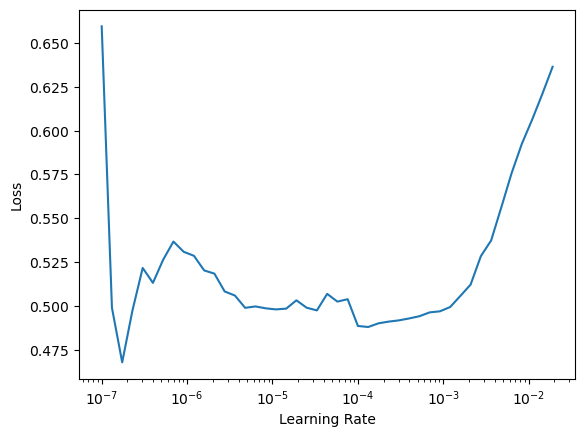

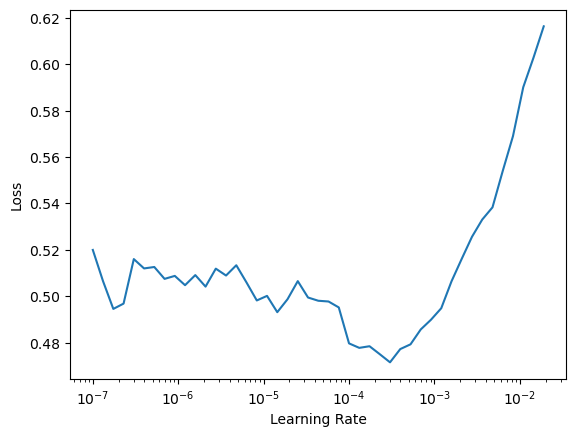

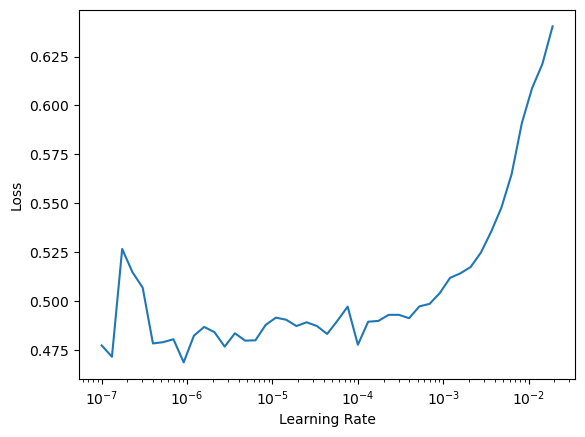

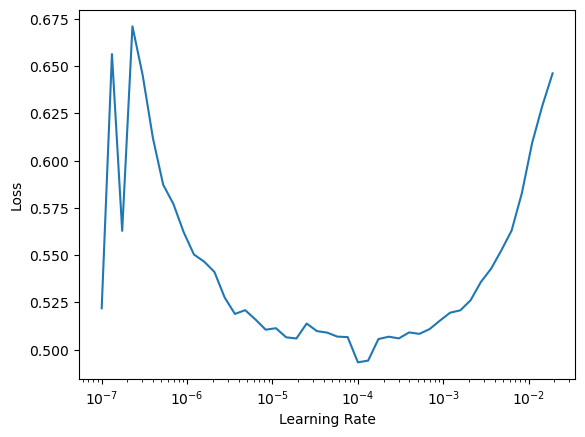

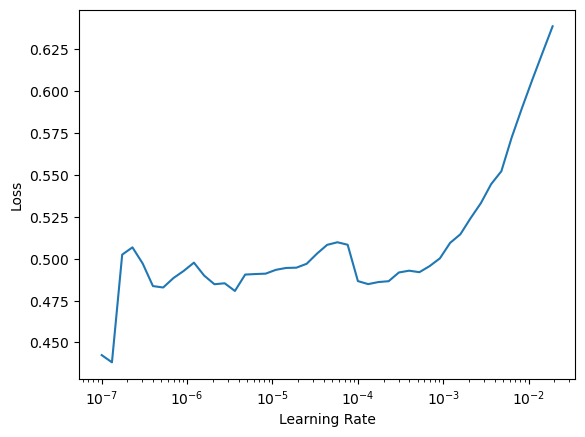

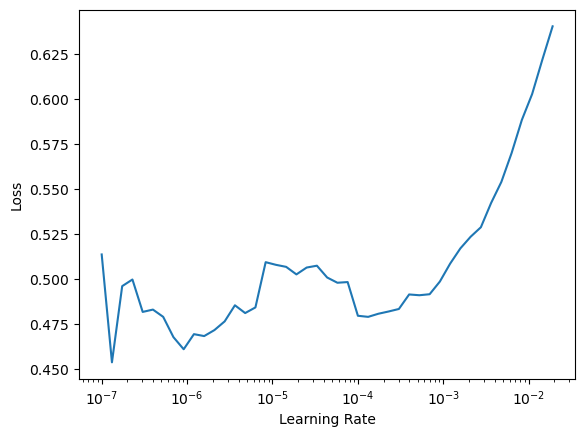

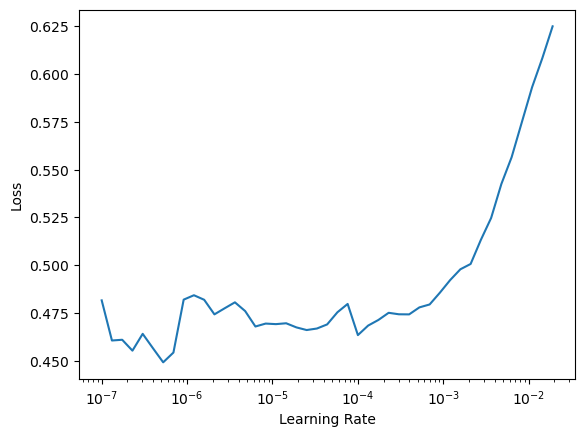

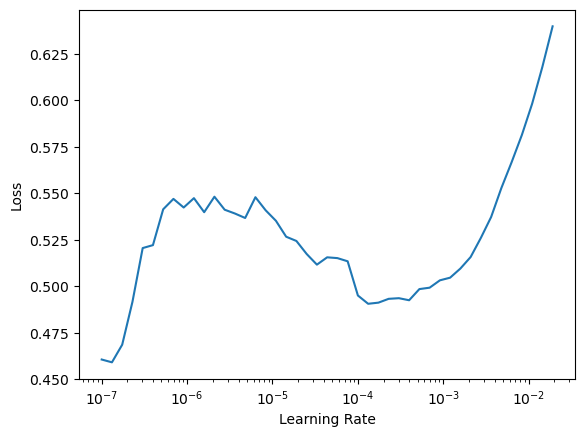

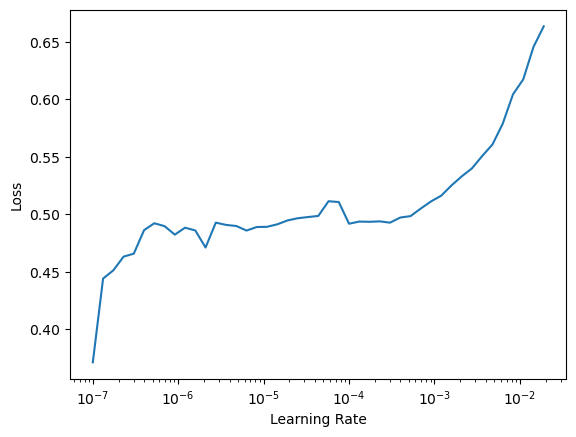

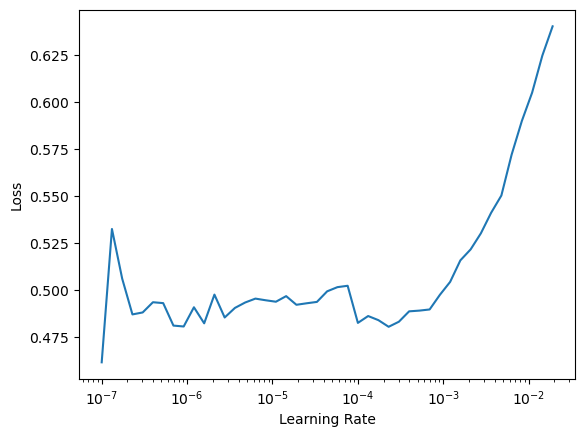

In [10]:

for i in range(10):
    n_epochs = 5
    learner1.fit_one_cycle(n_epochs,lr)
    
    PATH = f"model_3_unfreeze_{(i+1)*n_epochs}.mm"
    print("file:", PATH)
    torch.save(model.state_dict(), PATH)
    
    lr_min0,lr_steep0 = learner1.lr_find(start_lr=1e-7, end_lr=1e-1, num_it=50, stop_div=True, show_plot=True, suggestions=True)
    print((i+1), " lr_min,lr_steep: ",lr_min0,lr_steep0)

## unfreeze 2

In [ ]:
# load freeze results
model_path = "model_3_unfreeze_20.mm"
device = torch.device('cuda')
model.load_state_dict(torch.load(model_path, map_location=device))



0 :  lr_min,lr_steep:  2.511886486900039e-06 1.4454397678775877e-08


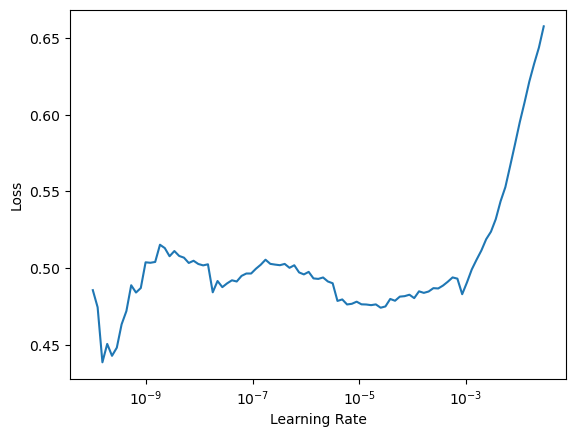

In [14]:
lr_min0,lr_steep0 = learner1.lr_find(start_lr=1e-10, end_lr=1e-1, num_it=100, stop_div=True, show_plot=True, suggestions=True)
print("0 :", " lr_min,lr_steep: ",lr_min0,lr_steep0)
# lr = lr_min0/10

# lr = slice(2e-6/10,2e-6) # meh

lr = 2e-8 # very good
# lr = slice(8e-5/1000,8e-5) # started very well then dropped


In [ ]:

for i in range(10):
    n_epochs = 5
    learner1.fit_one_cycle(n_epochs,lr)
    
    PATH = f"model_3_unfreeze2_{(i+1)*n_epochs}.mm"
    print("file:", PATH)
    torch.save(model.state_dict(), PATH)
    
    lr_min0,lr_steep0 = learner1.lr_find(start_lr=1e-10, end_lr=1e-1, num_it=50, stop_div=True, show_plot=True, suggestions=True)
    print((i+1), " lr_min,lr_steep: ",lr_min0,lr_steep0)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.477577,0.376902,0.679243,00:06
1,0.483059,0.379361,0.664643,00:06
2,0.482841,0.378430,0.671512,00:06
3,0.490692,0.378089,0.678729,00:06
4,0.482126,0.380598,0.665053,00:06


file: model_3_unfreeze2_5.mm


1  lr_min,lr_steep:  3.801894126809202e-06 2.0892962311336305e-06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.492158,0.381098,0.675171,00:06
1,0.492239,0.380472,0.673532,00:06
2,0.485950,0.382949,0.662854,00:06
3,0.484304,0.378661,0.671422,00:06
4,0.478994,0.380913,0.659001,00:06


file: model_3_unfreeze2_10.mm


2  lr_min,lr_steep:  1.995262282434851e-05 2.0892962311336305e-06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.498036,0.380424,0.666172,00:06
1,0.481309,0.380533,0.669601,00:06
2,0.489098,0.380740,0.666692,00:06
3,0.479791,0.380701,0.655494,00:06
4,0.474533,0.379822,0.635921,00:05


file: model_3_unfreeze2_15.mm


3  lr_min,lr_steep:  4.78630090583465e-07 2.0892962311336305e-06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.481571,0.377637,0.663544,00:06
1,0.482161,0.380889,0.667088,00:06
2,0.489409,0.381318,0.667311,00:06
3,0.480529,0.380357,0.670145,00:06
4,0.483308,0.379169,0.668657,00:06


file: model_3_unfreeze2_20.mm


4  lr_min,lr_steep:  1.8197008344600363e-10 2.0892962311336305e-06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.477456,0.380752,0.661218,00:06
1,0.474624,0.380950,0.660641,00:06
2,0.477586,0.379843,0.663423,00:06
3,0.475751,0.379983,0.669774,00:06
4,0.473223,0.380235,0.671898,00:06


file: model_3_unfreeze2_25.mm


5  lr_min,lr_steep:  3.162277607771102e-07 2.0892962311336305e-06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.454243,0.380812,0.669891,00:06
1,0.473311,0.380337,0.663382,00:06
2,0.480455,0.381008,0.646249,00:06
3,0.476372,0.378494,0.644076,00:05
4,0.478156,0.380688,0.651078,00:06


file: model_3_unfreeze2_30.mm


6  lr_min,lr_steep:  4.1686938345719683e-10 2.0892962311336305e-06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.489192,0.378931,0.659659,00:06
1,0.477945,0.380702,0.657061,00:06
2,0.474618,0.379264,0.677316,00:06
3,0.491159,0.378816,0.675929,00:06
4,0.489898,0.379947,0.677436,00:06


file: model_3_unfreeze2_35.mm


7  lr_min,lr_steep:  7.94328214315243e-11 2.0892962311336305e-06


epoch,train_loss,valid_loss,COCOMetric,time
0,0.484463,0.379489,0.668320,00:06
1,0.484435,0.379899,0.659785,00:06
2,0.473509,0.382053,0.667934,00:06
